<a href="https://colab.research.google.com/github/sboonpan/Project_Stock_LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install yfinance

In [38]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

%matplotlib inline 

In [39]:
symbol = 'PTT.BK'
start  = '2000-01-01'
end    = '2020-12-31'
stock = yf.download(symbol, start, end) 
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-12-06,3.800,3.825,3.55,3.575,1.553146,1736808000
2001-12-07,3.625,3.625,3.55,3.550,1.542285,412533000
2001-12-10,3.550,3.550,3.55,3.550,1.542285,0
2001-12-11,3.550,3.550,3.40,3.400,1.477117,409158000
2001-12-12,3.425,3.525,3.40,3.500,1.520562,307291000
...,...,...,...,...,...,...
2020-12-24,40.750,41.500,40.75,41.250,39.227222,45405500
2020-12-25,41.250,42.250,41.25,42.000,39.940445,32414000
2020-12-28,42.250,42.750,41.00,41.000,38.989479,60698100


In [40]:
df = stock.copy()

In [41]:
# Replace 0 to avoid dividing by 0 later on
#df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
#df.sort_values('Date', inplace=True)
df.drop(columns = 'Volume', inplace = True)
df

,Open,High,Low,Close,Adj Close
Date,,,,,
2001-12-06,3.800,3.825,3.55,3.575,1.553146
2001-12-07,3.625,3.625,3.55,3.550,1.542285
2001-12-10,3.550,3.550,3.55,3.550,1.542285
2001-12-11,3.550,3.550,3.40,3.400,1.477117
2001-12-12,3.425,3.525,3.40,3.500,1.520562
...,...,...,...,...,...
2020-12-24,40.750,41.500,40.75,41.250,39.227222
2020-12-25,41.250,42.250,41.25,42.000,39.940445
2020-12-28,42.250,42.750,41.00,41.000,38.989479


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4729 entries, 2001-12-06 to 2020-12-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4729 non-null   float64
 1   High       4729 non-null   float64
 2   Low        4729 non-null   float64
 3   Close      4729 non-null   float64
 4   Adj Close  4729 non-null   float64
dtypes: float64(5)
memory usage: 221.7 KB


In [43]:
#df['Target'] = df['Adj Close'].shift(1)

In [44]:
#df

In [45]:
#df.dropna(inplace = True)
#df

In [46]:
test_split=round(len(df)*0.20)

In [47]:
test_split

946

In [48]:
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]

In [49]:
print(df_for_training.shape)
print(df_for_testing.shape)

(3783, 5)
(946, 5)


In [50]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [51]:
df_for_testing_scaled=scaler.transform(df_for_testing)

In [52]:
df_for_training_scaled

array([[0.02211302, 0.02250608, 0.0170778 , 0.01642336, 0.00604818],
       [0.01781327, 0.0176399 , 0.0170778 , 0.01581508, 0.00571609],
       [0.01597051, 0.01581508, 0.0170778 , 0.01581508, 0.00571609],
       ...,
       [0.93611797, 0.9318735 , 0.92409867, 0.8880779 , 0.93553009],
       [0.90663392, 0.8978102 , 0.92156857, 0.892944  , 0.94048922],
       [0.89680597, 0.8880779 , 0.90385824, 0.8686131 , 0.91569301]])

In [53]:
df_for_training_scaled.shape

(3783, 5)

In [54]:
df_for_testing_scaled

array([[0.87960693, 0.89537715, 0.90385824, 0.89537715, 0.94296898],
       [0.90417696, 0.8978102 , 0.91650846, 0.8880779 , 0.93553009],
       [0.89926293, 0.90024335, 0.92662868, 0.892944  , 0.94048922],
       ...,
       [0.9668305 , 0.96958637, 0.96457934, 0.9270073 , 1.15071942],
       [0.94226048, 0.96350365, 0.96457934, 0.96350365, 1.1943352 ],
       [0.99140053, 0.98175182, 0.9962049 , 0.96350365, 1.1943352 ]])

In [55]:
df_for_testing_scaled.shape

(946, 5)

In [56]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,-1])
    return np.array(dataX),np.array(dataY) 

In [57]:
trainX,trainY=createXY(df_for_training_scaled,30)

In [58]:
trainX.shape

(3753, 30, 5)

In [59]:
testX,testY=createXY(df_for_testing_scaled,30)

In [60]:
trainX[0]

array([[0.02211302, 0.02250608, 0.0170778 , 0.01642336, 0.00604818],
       [0.01781327, 0.0176399 , 0.0170778 , 0.01581508, 0.00571609],
       [0.01597051, 0.01581508, 0.0170778 , 0.01581508, 0.00571609],
       [0.01597051, 0.01581508, 0.01328273, 0.01216545, 0.0037235 ],
       [0.01289926, 0.01520681, 0.01328273, 0.01459854, 0.00505189],
       [0.01474201, 0.01520681, 0.01581278, 0.01459854, 0.00505189],
       [0.01474201, 0.01520681, 0.01454776, 0.01338199, 0.00438769],
       [0.01412776, 0.01399026, 0.01454776, 0.01338199, 0.00438769],
       [0.01351351, 0.01338199, 0.01454776, 0.01338199, 0.00438769],
       [0.01351351, 0.01399026, 0.01391524, 0.01277372, 0.00405561],
       [0.01289926, 0.01399026, 0.01391524, 0.01338199, 0.00438769],
       [0.01351351, 0.01399026, 0.01391524, 0.01277372, 0.00405561],
       [0.01289926, 0.01338199, 0.01391524, 0.01277372, 0.00405561],
       [0.01289926, 0.01338199, 0.01391524, 0.01277372, 0.00405561],
       [0.01289926, 0.01399026, 0.

In [61]:
trainY[0]

0.004719783294818619

In [62]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (3753, 30, 5)
trainY Shape--  (3753,)


In [63]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (916, 30, 5)
testY Shape--  (916,)


In [64]:
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.02211302 0.02250608 0.0170778  0.01642336 0.00604818]
 [0.01781327 0.0176399  0.0170778  0.01581508 0.00571609]
 [0.01597051 0.01581508 0.0170778  0.01581508 0.00571609]
 [0.01597051 0.01581508 0.01328273 0.01216545 0.0037235 ]
 [0.01289926 0.01520681 0.01328273 0.01459854 0.00505189]
 [0.01474201 0.01520681 0.01581278 0.01459854 0.00505189]
 [0.01474201 0.01520681 0.01454776 0.01338199 0.00438769]
 [0.01412776 0.01399026 0.01454776 0.01338199 0.00438769]
 [0.01351351 0.01338199 0.01454776 0.01338199 0.00438769]
 [0.01351351 0.01399026 0.01391524 0.01277372 0.00405561]
 [0.01289926 0.01399026 0.01391524 0.01338199 0.00438769]
 [0.01351351 0.01399026 0.01391524 0.01277372 0.00405561]
 [0.01289926 0.01338199 0.01391524 0.01277372 0.00405561]
 [0.01289926 0.01338199 0.01391524 0.01277372 0.00405561]
 [0.01289926 0.01399026 0.01391524 0.01277372 0.00405561]
 [0.01351351 0.01399026 0.01454776 0.01277372 0.00405561]
 [0.01351351 0.01399026 0.01391524 0.01338199 0.00438769]


In [65]:
trainY[0]

0.004719783294818619

In [66]:
trainY.shape

(3753,)

In [67]:
trainX[1]

array([[0.01781327, 0.0176399 , 0.0170778 , 0.01581508, 0.00571609],
       [0.01597051, 0.01581508, 0.0170778 , 0.01581508, 0.00571609],
       [0.01597051, 0.01581508, 0.01328273, 0.01216545, 0.0037235 ],
       [0.01289926, 0.01520681, 0.01328273, 0.01459854, 0.00505189],
       [0.01474201, 0.01520681, 0.01581278, 0.01459854, 0.00505189],
       [0.01474201, 0.01520681, 0.01454776, 0.01338199, 0.00438769],
       [0.01412776, 0.01399026, 0.01454776, 0.01338199, 0.00438769],
       [0.01351351, 0.01338199, 0.01454776, 0.01338199, 0.00438769],
       [0.01351351, 0.01399026, 0.01391524, 0.01277372, 0.00405561],
       [0.01289926, 0.01399026, 0.01391524, 0.01338199, 0.00438769],
       [0.01351351, 0.01399026, 0.01391524, 0.01277372, 0.00405561],
       [0.01289926, 0.01338199, 0.01391524, 0.01277372, 0.00405561],
       [0.01289926, 0.01338199, 0.01391524, 0.01277372, 0.00405561],
       [0.01289926, 0.01399026, 0.01391524, 0.01277372, 0.00405561],
       [0.01351351, 0.01399026, 0.

In [68]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [69]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [16,32,64,128],
              'epochs' : [5,10,15,20],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 4)

In [70]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/5
176/176 [==============================] - 11s 20ms/step - loss: 0.0138 - val_loss: 0.0068
Epoch 2/5
176/176 [==============================] - 2s 12ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 3/5
176/176 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0062
Epoch 4/5
176/176 [==============================] - 2s 14ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 5/5
59/59 [==============================] - 0s 6ms/step - loss: 1.7658e-04
Epoch 1/5
176/176 [==============================] - 7s 11ms/step - loss: 0.0107 - val_loss: 0.0068
Epoch 2/5
176/176 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 3/5
176/176 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 4/5
176/176 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 5/5
59/59 [==============================] - 0s 4ms/step - loss: 4.5582e-04
Epoch 1/5
176/176 [===================

In [71]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [72]:
my_model=grid_search.best_estimator_.model

In [73]:
my_model

In [74]:
prediction=my_model.predict(testX)

In [75]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.91470486]
 [0.91319793]
 [0.91175634]
 [0.9078501 ]
 [0.9052112 ]
 [0.903755  ]
 [0.9025773 ]
 [0.90243506]
 [0.904131  ]
 [0.90624905]
 [0.90924865]
 [0.91087765]
 [0.9113673 ]
 [0.91151977]
 [0.911124  ]
 [0.90980357]
 [0.9078964 ]
 [0.90606236]
 [0.9039331 ]
 [0.90192753]
 [0.9010416 ]
 [0.90044814]
 [0.90019536]
 [0.9006033 ]
 [0.90071094]
 [0.9002198 ]
 [0.8991546 ]
 [0.8958307 ]
 [0.8941732 ]
 [0.8958046 ]
 [0.89740366]
 [0.8997569 ]
 [0.9024614 ]
 [0.9050004 ]
 [0.90715873]
 [0.90947235]
 [0.9112188 ]
 [0.9118026 ]
 [0.9123311 ]
 [0.91206145]
 [0.9117212 ]
 [0.91016936]
 [0.90874285]
 [0.90469164]
 [0.90048325]
 [0.8973019 ]
 [0.893545  ]
 [0.89048254]
 [0.88776046]
 [0.8867211 ]
 [0.8867509 ]
 [0.8856166 ]
 [0.8837667 ]
 [0.88254756]
 [0.8829301 ]
 [0.8815893 ]
 [0.8799584 ]
 [0.87930644]
 [0.8789865 ]
 [0.8791016 ]
 [0.87835276]
 [0.8765558 ]
 [0.8725632 ]
 [0.86928385]
 [0.8674795 ]
 [0.8659329 ]
 [0.86297286]
 [0.8617105 ]
 [0.8616296 ]
 [0.8618879 ]
 [0.8635

In [76]:
prediction.shape

(916, 1)

In [77]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [78]:
prediction_copies_array.shape

(916, 5)

In [79]:
prediction_copies_array

array([[0.91470486, 0.91470486, 0.91470486, 0.91470486, 0.91470486],
       [0.91319793, 0.91319793, 0.91319793, 0.91319793, 0.91319793],
       [0.91175634, 0.91175634, 0.91175634, 0.91175634, 0.91175634],
       ...,
       [1.0826983 , 1.0826983 , 1.0826983 , 1.0826983 , 1.0826983 ],
       [1.0815268 , 1.0815268 , 1.0815268 , 1.0815268 , 1.0815268 ],
       [1.0849887 , 1.0849887 , 1.0849887 , 1.0849887 , 1.0849887 ]],
      dtype=float32)

In [80]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,-1]

In [81]:
pred

array([31.270653, 31.221369, 31.174221, 31.046467, 30.960163, 30.912539,
       30.874022, 30.86937 , 30.924835, 30.994106, 31.092207, 31.145483,
       31.161497, 31.166483, 31.15354 , 31.110355, 31.047981, 30.988   ,
       30.918364, 30.852772, 30.823797, 30.804388, 30.79612 , 30.809462,
       30.812983, 30.796919, 30.762083, 30.653374, 30.599167, 30.652521,
       30.704819, 30.78178 , 30.870232, 30.953268, 31.023857, 31.099524,
       31.156641, 31.175734, 31.193018, 31.1842  , 31.173073, 31.122318,
       31.075665, 30.94317 , 30.805536, 30.70149 , 30.57862 , 30.478464,
       30.389439, 30.355446, 30.35642 , 30.319324, 30.258823, 30.218952,
       30.231462, 30.18761 , 30.134274, 30.112951, 30.102488, 30.10625 ,
       30.08176 , 30.022991, 29.892414, 29.785164, 29.726152, 29.67557 ,
       29.578764, 29.537477, 29.534832, 29.54328 , 29.596338, 29.641853,
       29.699848, 29.795872, 29.908049, 29.987652, 30.034588, 30.053146,
       30.131716, 30.283388, 30.437834, 30.5646  , 

In [82]:
original_copies_array = np.repeat(testY, 5, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,-1]

In [83]:
pred

array([31.270653, 31.221369, 31.174221, 31.046467, 30.960163, 30.912539,
       30.874022, 30.86937 , 30.924835, 30.994106, 31.092207, 31.145483,
       31.161497, 31.166483, 31.15354 , 31.110355, 31.047981, 30.988   ,
       30.918364, 30.852772, 30.823797, 30.804388, 30.79612 , 30.809462,
       30.812983, 30.796919, 30.762083, 30.653374, 30.599167, 30.652521,
       30.704819, 30.78178 , 30.870232, 30.953268, 31.023857, 31.099524,
       31.156641, 31.175734, 31.193018, 31.1842  , 31.173073, 31.122318,
       31.075665, 30.94317 , 30.805536, 30.70149 , 30.57862 , 30.478464,
       30.389439, 30.355446, 30.35642 , 30.319324, 30.258823, 30.218952,
       30.231462, 30.18761 , 30.134274, 30.112951, 30.102488, 30.10625 ,
       30.08176 , 30.022991, 29.892414, 29.785164, 29.726152, 29.67557 ,
       29.578764, 29.537477, 29.534832, 29.54328 , 29.596338, 29.641853,
       29.699848, 29.795872, 29.908049, 29.987652, 30.034588, 30.053146,
       30.131716, 30.283388, 30.437834, 30.5646  , 

In [84]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [31.270653 31.221369 31.174221 31.046467 30.960163 30.912539 30.874022
 30.86937  30.924835 30.994106 31.092207 31.145483 31.161497 31.166483
 31.15354  31.110355 31.047981 30.988    30.918364 30.852772 30.823797
 30.804388 30.79612  30.809462 30.812983 30.796919 30.762083 30.653374
 30.599167 30.652521 30.704819 30.78178  30.870232 30.953268 31.023857
 31.099524 31.156641 31.175734 31.193018 31.1842   31.173073 31.122318
 31.075665 30.94317  30.805536 30.70149  30.57862  30.478464 30.389439
 30.355446 30.35642  30.319324 30.258823 30.218952 30.231462 30.18761
 30.134274 30.112951 30.102488 30.10625  30.08176  30.022991 29.892414
 29.785164 29.726152 29.67557  29.578764 29.537477 29.534832 29.54328
 29.596338 29.641853 29.699848 29.795872 29.908049 29.987652 30.034588
 30.053146 30.131716 30.283388 30.437834 30.5646   30.636236 30.611492
 30.534119 30.448988 30.388645 30.34867  30.341156 30.33668  30.314768
 30.330744 30.358114 30.39963  30.484064 30.635347 30.77799  30.

In [85]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [31.270653 31.221369 31.174221 31.046467 30.960163 30.912539 30.874022
 30.86937  30.924835 30.994106 31.092207 31.145483 31.161497 31.166483
 31.15354  31.110355 31.047981 30.988    30.918364 30.852772 30.823797
 30.804388 30.79612  30.809462 30.812983 30.796919 30.762083 30.653374
 30.599167 30.652521 30.704819 30.78178  30.870232 30.953268 31.023857
 31.099524 31.156641 31.175734 31.193018 31.1842   31.173073 31.122318
 31.075665 30.94317  30.805536 30.70149  30.57862  30.478464 30.389439
 30.355446 30.35642  30.319324 30.258823 30.218952 30.231462 30.18761
 30.134274 30.112951 30.102488 30.10625  30.08176  30.022991 29.892414
 29.785164 29.726152 29.67557  29.578764 29.537477 29.534832 29.54328
 29.596338 29.641853 29.699848 29.795872 29.908049 29.987652 30.034588
 30.053146 30.131716 30.283388 30.437834 30.5646   30.636236 30.611492
 30.534119 30.448988 30.388645 30.34867  30.341156 30.33668  30.314768
 30.330744 30.358114 30.39963  30.484064 30.635347 30.77799  30.

In [86]:
import matplotlib.pyplot as plt

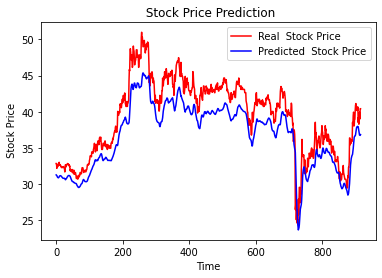

In [87]:
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()